# Practical 3: CIFAR-10

This is the second task of Practical 3. Your task is to use **transfer learning** to build a convolutional neural network to tackle the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
You could select an existing trained model (VGG16 excluded) from Keras (https://keras.io/api/applications/) and fine-tune it to build a classifier for CIFAR-10.

We will grade your code based on the accuracy of your model. 
Your CNN should achieve at least an accuracy of 75% to pass the practical.
You can get 5 bonus points by achieving an accuracy of 85%+.


The model files might be too large to be uploaded to GitHub. 
Please use the following link to upload your models: https://seafile.ifi.uzh.ch/u/d/695f63e725b641ed8633/

Name the model file `{repository_name}-CIFAR10.h5`. For example, if your repository is FDS22-M0, you should name the model file `FDS22-M0-CIFAR10.h5`. If you are not satisfied with the model you have uploaded, you can upload a new one with the same name. We will only look at the newest model. Nevertheless, try to upload as few times as possible, since the online drive has a limited amount of space. 

## Import the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.__version__

'2.9.2'

In [ ]:
tf.keras.__version__

'2.9.0'

## Prepare the dataset

In this block, you will prepare the data for the training, such as apply the preprocess function of your selected model and perform data augmentation. 

170498071/170498071 [==============================] - 13s 0us/step


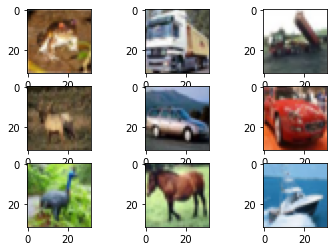

(50000, 32, 32, 3)

In [ ]:
from keras.datasets import cifar10
from keras.applications.vgg19 import preprocess_input 
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

X_train_full = X_train_full.astype('float32')

# preprocess
X_train_full = preprocess_input(X_train_full)
X_test = preprocess_input(X_test)
# one-hot encoding
y_train_full = keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# get validation dataset
np.random.seed(42) # we set the random seed to make sure everytime the data is shuffled in the same way 
shuffled_indices = np.random.permutation(X_train_full.shape[0])
X_valid, X_train = X_train_full[shuffled_indices[:5000]], X_train_full[shuffled_indices[5000:]]
y_valid, y_train = y_train_full[shuffled_indices[:5000]], y_train_full[shuffled_indices[5000:]]

X_train_full.shape

# Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=15, horizontal_flip=True, zoom_range=0.1)
train_data_generator= datagen.flow(X_train, y_train, batch_size=32)


## Build and train the model

Build and train your model. 

In [ ]:
# TODO: load the model you selected
vgg19_model = tf.keras.applications.vgg19.VGG19(include_top=False, input_shape=(32, 32, 3), weights='imagenet')
vgg19_model.summary()

x = vgg19_model.get_layer("block2_pool").output

x = keras.layers.Conv2D(filters=256, kernel_size=(3,3), kernel_initializer='he_uniform', padding="same")(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.MaxPool2D()(x)
x = keras.layers.Dropout(0.4)(x)

x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), kernel_initializer='he_uniform', padding="same")(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.MaxPool2D()(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), kernel_initializer='he_uniform', padding="same")(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.GlobalAveragePooling2D()(x)

output = keras.layers.Dense(units=10, activation='softmax', kernel_initializer='he_uniform')(x) # output layer with softmax activation
model = keras.Model(inputs=vgg19_model.input, outputs=output)

# freeze the layers from VGG19
for layer in vgg19_model.layers:
    layer.trainable=False


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
# show the structure of your model
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data_generator, 
          steps_per_epoch = len(X_train) / 32,
          epochs=30,
          validation_data=(X_valid, y_valid))

Epoch 1/30
1406/1406 [==============================] - 29s 20ms/step - loss: 1.1444 - accuracy: 0.6029 - val_loss: 0.9335 - val_accuracy: 0.6770
Epoch 2/30
1406/1406 [==============================] - 28s 20ms/step - loss: 0.8982 - accuracy: 0.6887 - val_loss: 0.7660 - val_accuracy: 0.7406
Epoch 3/30
1406/1406 [==============================] - 29s 20ms/step - loss: 0.8130 - accuracy: 0.7187 - val_loss: 0.7436 - val_accuracy: 0.7528
Epoch 4/30
1406/1406 [==============================] - 28s 20ms/step - loss: 0.7569 - accuracy: 0.7375 - val_loss: 0.7144 - val_accuracy: 0.7602
Epoch 5/30
1406/1406 [==============================] - 28s 20ms/step - loss: 0.7185 - accuracy: 0.7499 - val_loss: 0.5946 - val_accuracy: 0.7986
Epoch 6/30
1406/1406 [==============================] - 28s 20ms/step - loss: 0.6896 - accuracy: 0.7614 - val_loss: 0.6302 - val_accuracy: 0.7822
Epoch 7/30
1406/1406 [==============================] - 28s 20ms/step - loss: 0.6545 - accuracy: 0.7725 - val_loss: 0.5268 -

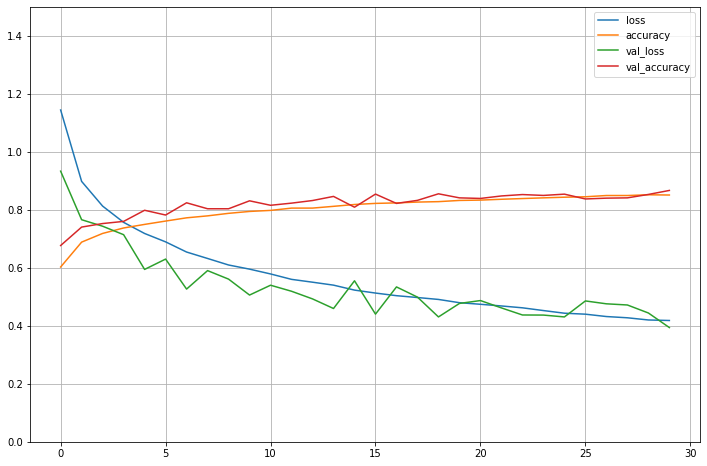

In [ ]:
# Assume you have stored the training history in the variable "history"
# Show the learning curves
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1.5)
plt.grid(True)
plt.show()

## Save the model

Save and upload your trained model to the **Seafile link** we provided to you. You can upload it multiple times. We will consider only the newest uploaded model. 

In [ ]:
model.save('FDS22-M001-CIFAR10.h5')  # change the file name according to your repository name

## Load the model and evaluate it on the test data

In [ ]:
model = keras.models.load_model('FDS22-M001-CIFAR10.h5')
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.4107 - accuracy: 0.8611


[0.4107150435447693, 0.8611000180244446]

## Short report

Please write a few sentences explaining how you build and train the model. Please include the decisions you made, such as how you decide the number of layers reused from the selected model and the difficulties you met.

At the beginning, we only used local RAM resources to run the program, resulting in very slow running speed. Later, we use Google’s GPU resources, which is used to accelerate the calculation of tasks related to graphics and deep learning. We found that he running speed was greatly improved. Regarding to model we built, we simply applied the architecture in the sample code to train our model and applied all the layers of pre-trained VGG-19 model at first. The result was only about 76%. In addition, we did not use LeakyReLU method in VGG-19, there appears a gradient explosion, which caused our training process to fail. Through our discussion, analysis of various principles and review of paper methods, we outlined the methods and justifications we employed below.

In our practical, we use **ImageDataGenerator** (Lai, 2020) to expand the data, we set rotation_range to 15 which enable it to generate figure with random rotations of 15 degrees, horizontal_flip is set to true enable it to flip the figures horizontally and we also set 0.1 for random zoom. Through these transformations, we can use the newly generated image data as training data. In this way, we can train the model with less data while improving the generalization ability of the model.

For **transfer learning**, we use the trained **VGG-19** (Namani et al., 2022) model. VGG-19 is pre-trained on the ImageNet dataset, a large image dataset containing more than 10 million images covering 1000 different categories, which is quite different from our number of categories, so we want to reuse the shallower layers, because they may be more general for our CIFAR-10 images and can be used to extract general features of images. For our choice we decided to transfer learning the first **2** convolutional blocks of VGG-19 and tried to supplement and improve the remaining 3 convolutional blocks. 

The VGG-19 pre-trained model adopts the ReLU layer (f(x) = max(0, x)), so that the slope of the ReLU function is 0 when x<0,it may cause the problem of gradient disappearance. We didn't change it at the beginning so it caused a gradient explosion when training to about 20 epochs, and then we added the **LeakyReLU layer** (f(x) = max(alpha * x, x)). The advantage of LeakyReLU is that the slope is not 0 when x<0, but a small positive number (Nayef et al., 2022). This improvement can avoid the problem of gradient disappearance and explosion, making LeakyReLU more stable when training deep neural networks. 

We used **batchnormalization** to make network easier to train, speed up convergence, and make training more stable. It does this by normalizing the input data. This means adjusting the mean of the data to 0 and the variance to 1 so that the input data has a similar distribution, and each batch of data is normalized before being fed into the next layer. This helps alleviate the gradient vanishing/exploding problem and also speeds up the training of the model (Wang et al., 2022). 

To reduce the complexity of the model and prevent overfitting, we added a **dropout** ratio of 0.4 and 0.5, which is equivalent to discarding 40% of the input units in the third convolutional layers, and 50% in the fourth convolutional layers. 

At the same time, we added a **GlobalAveragePooling layer** after the fifth convolutional layer, which can average each element of the input matrix to get a single number, which helps to reduce the complexity of the model and preserves the performance of the neural network while reducing the size of the model.

In general, we improve the subsequent training process by transferring learning the first two convolution blocks of VGG-19 and by LeakyReLU, Batchnormalization, Dropout, and GlobalAveragePooling methods. After our improvement, the final evaluation effect of our model can reach a satisfactory **86.11%**. Compared with transfer learning all layers of the VGG-19 pre-training model (76%), it has increased by more than 10%.


**Reference**

Lai, K.-T. (2020). Convolutional Neural Network.

Namani, S., Akkapeddi, L. S., & Bantu, S. (2022). Performance Analysis of VGG-19 Deep Learning Model for COVID-19 Detection. 2022 9th International Conference on Computing for Sustainable Global Development (INDIACom)

Nayef, B. H., Abdullah, S. N. H. S., Sulaiman, R., & Alyasseri, Z. A. A. (2022). Optimized leaky ReLU for handwritten Arabic character recognition using convolution neural networks. Multimedia Tools and Applications, 81(2), 2065-2094. 

Shorten, C., & Khoshgoftaar, T. M. (2019). A survey on image data augmentation for deep learning. Journal of big data, 6(1), 1-48.

Singh, I., Singh, S. K., Kumar, S., & Aggarwal, K. (2022). Dropout-VGG based convolutional neural network for traffic sign categorization. Congress on Intelligent Systems.

Wang, X., Dong, C., & Shan, Y. (2022). RepSR: Training Efficient VGG-style Super-Resolution Networks with Structural Re-Parameterization and Batch Normalization. arXiv preprint arXiv:2205.05671. 

